# Cartpole Challenge

In [1]:
import time
import gym
import random
import numpy as np
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from statistics import mean, median
from collections import Counter
import tensorflow as tf
from functools import reduce
from tqdm import tqdm


import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
env.reset()

sess = tf.Session()

C:\Users\Blup\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Create random training Data
Create random training data and keep above avarage performing examples.

In [2]:
def create_training_data(n_games=100, percentile_threshold=75, model=False):
    games = []
    for iteration in tqdm(range(n_games), mininterval=2, desc="create_training_data n_games"):
        #if(iteration % 1000 == 0):
        #    print('Training data generation iteration ' + str(iteration) + '/' + str(n_games))
        
        score = 0
        game_data = []
        prev_observation = env.reset()
        while True:
            
            if(model):
                tflearn.is_training(False, sess)
                action = np.argmax(model.predict(prev_observation.reshape(-1, len(prev_observation), 1)) [0])
            else:
                action = random.randrange(0,2)
                
            observation, reward, done, info = env.step(action)
            
            action_one_hot = [0,1] if (action == 1) else [1,0]
            game_data.append([prev_observation, action_one_hot])
            
            prev_observation = observation
            
            deviation_from_center = np.absolute(observation[0])
            score += reward - deviation_from_center
            
            if done:
                break
        games.append([score, game_data])
        
        
    #training_data_save = np.array(training_data)
    #np.save('saved.npy', training_data_save)

    scores = list(map(lambda game: game[0], games))
    score_threshold = np.percentile( scores , percentile_threshold)

    games = list(filter( (lambda game: game[0]>=score_threshold), games))
    training_data_by_game = list(map( (lambda game: game[1]), games))
    flat_training_data = reduce(lambda x,y: x+y, training_data_by_game)
    
    plt.hist(scores, bins=30)
    plt.title('Scores for random training data')
    plt.axvline(x=score_threshold, color='r')
    plt.text(score_threshold,-1,'threshold',rotation=90)

    
    return flat_training_data


Executing this should result in a decent training set.

create_training_data n_games: 100%|██████████| 100/100 [00:00<00:00, 2945.71it/s]


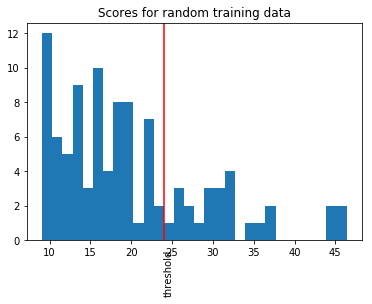

In [3]:
random_training_data = create_training_data(n_games=100, percentile_threshold=75)

# Create the model

In [4]:
def create_model(learning_rate=1e-3):
    print("Creating model")
    
    input_size = 4
    network = input_data(shape = [None, input_size, 1], name='input')
    
    network = fully_connected(network, 16, activation='relu')
    #network = dropout(network, 0.8)

    network = fully_connected(network, 16, activation='relu')
    #network = dropout(network, 0.8)


    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=learning_rate, 
                    loss = 'categorical_crossentropy', name='targets')

    model = tflearn.DNN(network, tensorboard_dir='log')
    return model

In [5]:
def train_model(training_data, model=False, n_epoch=1):
    tflearn.is_training(True, sess)
    
    print("Reshaping array")
    X = np.array([i[0] for i in training_data]).reshape(-1, len(training_data[0][0]), 1)
    Y = [i[1] for i in training_data]

    if not model:
        model = create_model()
    
    print("Training model")
    model.fit({'input':X}, {'targets':Y}, n_epoch=n_epoch, snapshot_step=500, show_metric=True,
                run_id='fit'+str(int(time.time())))

    return model

Training Step: 1521  | total loss: 0.68066 | time: 23.356s
| Adam | epoch: 001 | loss: 0.68066 - acc: 0.5858 -- iter: 97344/97351
Training Step: 1522  | total loss: 0.68099 | time: 23.368s
| Adam | epoch: 001 | loss: 0.68099 - acc: 0.5834 -- iter: 97351/97351
--


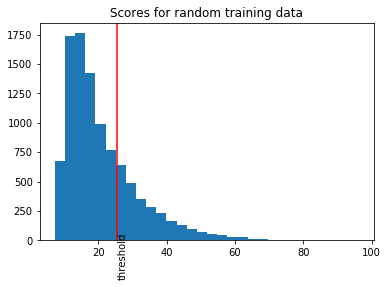

In [6]:
random_training_data = create_training_data(n_games=10000, percentile_threshold=75)
model = create_model(learning_rate=1e-3)
model = train_model(random_training_data, model)

The optimizer is not able to achieve accuracies over 60% which makes sense since we fed it mostly random data.
On next iterations the DNN should be able to reproduce the results of all runs with a score above the 75 percentile.

Training Step: 6210  | total loss: 0.04217 | time: 22.242s
| Adam | epoch: 004 | loss: 0.04217 - acc: 0.9933 -- iter: 099968/100000
Training Step: 6211  | total loss: 0.04204 | time: 22.257s
| Adam | epoch: 004 | loss: 0.04204 - acc: 0.9940 -- iter: 100000/100000
--


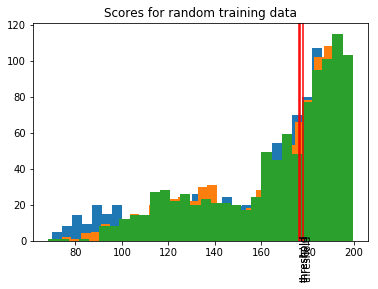

In [7]:
for _ in range(3):
    training_data = create_training_data(n_games=1000, percentile_threshold=50, model=model)
    model = train_model(training_data, model)

Two strange results:
* The model is not only reproducing the mediocre attempts but is significantly better. I would have expected results close to the 75 percentile of the first attempt, which should have scored around 30 and 40 and not around 180.
* Feeding the net further with the best attempts of previous runs does not improve the model. I seem to have hit a wall here.

Interpretation:
* 99% accuracy means I'm able to fit the training data. So I'd say there are no bias problems. 
* The model is not able to score well on test time which I'd interpret as a variance problem. 
 * More training data. Maybe put all 200 scoring runs into a bucket and train on them instead of X percentile of previous runs.
 * Regularization techniques like dropout and L2
* Model size seems to be sufficient at first glance. Otherwise it wouldnt be able to fit so well. Maybe introducing dropout will force me to increase my model size.